<a href="https://colab.research.google.com/github/aaayup/anomaly_detection/blob/main/ARIMA(uniform_all_predict).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df=pd.read_csv('/content/uniform_train_set.csv')
df = df.copy()
df.head()

,heart_rate1,event1,heart_rate10,event10,heart_rate100,event100,heart_rate1000,event1000,heart_rate101,event101,...,event995,heart_rate996,event996,heart_rate997,event997,heart_rate998,event998,heart_rate999,event999,update_time
0,100,0,83,0,76,0,66,0,97,0,...,0,73,0,62,0,96,0,78,0,01JAN2020:00:00:00
1,79,0,91,0,77,0,83,0,96,0,...,0,88,0,96,0,96,0,91,0,01JAN2020:00:10:00
2,61,0,69,0,87,0,91,0,83,0,...,0,89,0,95,0,98,0,78,0,01JAN2020:00:20:00
3,71,0,66,0,89,0,89,0,93,0,...,0,94,0,75,0,100,0,88,0,01JAN2020:00:30:00
4,90,0,90,0,69,0,67,0,95,0,...,0,90,0,66,0,68,0,98,0,01JAN2020:00:40:00


In [ ]:
df_s = df[['update_time']].copy()
df['update_time'] = pd.to_datetime(df['update_time'], format='%d%b%Y:%H:%M:%S')

# 'heart_rateX' 및 'eventX' 열을 만들고 선택하기 위해 루프를 사용합니다.
for i in range(1, 1001):
    df_s[f'heart_rate{i}'] = df[f'heart_rate{i}']
    df_s[f'event{i}'] = df[f'event{i}']

# 데이터를 df_train과 df_test로 분할
df_train = df_s[:1008]
df_test = df_s[1008:]

In [ ]:
for i in range(1, 1001):
    # ARIMA 모델 학습
    model = ARIMA(df_train[f'heart_rate{i}'], order=(1, 0, 3))
    result = model.fit()

    start_idx = 1008  # 테스트 데이터셋의 시작 인덱스
    end_idx = 1008 + len(df_test)  # 테스트 데이터셋의 끝 인덱스

    forecast = result.get_prediction(start=start_idx, end=end_idx, dynamic=False)

    # 신뢰구간과 예측값 할당
    forecast_ci = forecast.conf_int()

  # 데이터프레임에 신뢰구간 추가
    df_test[f'lower_{i}'] = forecast_ci.iloc[:, 0]
    df_test[f'upper_{i}'] = forecast_ci.iloc[:, 1]

       # 'pred_y{i}' 열이 이미 존재하는 경우 삭제하고 다시 추가 (insert 메서드 사용)
    if f'pred_y{i}' in df_test.columns:
       df_test.drop(columns=[f'pred_y{i}'], inplace=True)

    # 'pred_y{i}' 열을 'event{i}' 뒤에 생성
    df_test.insert(df_test.columns.get_loc(f'event{i}') + 1, f'pred_y{i}', np.where((df_test[f'heart_rate{i}'] < df_test[f'lower_{i}']) | (df_test[f'heart_rate{i}'] > df_test[f'upper_{i}']), 1, 0))

    # 'pred{i}', 'lower_{i}', 'upper_{i} 삭제
    if f'pred{i}' in df_test.columns:
        df_test.drop(columns=[f'pred{i}'], inplace = True)
    if f'lower_{i}' in df_test.columns:
        df_test.drop(columns=[f'lower_{i}'], inplace = True)
    if f'upper_{i}' in df_test.columns:
        df_test.drop(columns=[f'upper_{i}'], inplace = True)

In [ ]:
df_test

,update_time,heart_rate1,pred_y_1,event1,heart_rate2,pred_y_2,event2,heart_rate3,pred_y_3,event3,...,heart_rate996,event996,heart_rate997,event997,heart_rate998,event998,heart_rate999,event999,heart_rate1000,event1000
1008,08JAN2020:00:00:00,81,0,0,87,0,0,88,0,0,...,92,0,92,0,66,0,92,0,82,0
1009,08JAN2020:00:10:00,100,0,0,92,0,0,87,0,0,...,83,0,97,0,73,0,92,0,85,0
1010,08JAN2020:00:20:00,73,0,0,73,0,0,99,0,0,...,67,0,86,0,87,0,62,0,92,0
1011,08JAN2020:00:30:00,95,0,0,98,0,0,69,0,0,...,60,0,85,0,86,0,83,0,94,0
1012,08JAN2020:00:40:00,91,0,0,68,0,0,100,0,0,...,79,0,60,0,136,1,84,0,72,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,10JAN2020:08:10:00,109,0,1,73,0,0,72,0,0,...,93,0,62,0,88,0,137,1,100,0
1346,10JAN2020:08:20:00,71,0,0,85,0,0,132,1,1,...,80,0,99,0,93,0,108,1,71,0
1347,10JAN2020:08:30:00,83,0,0,88,0,0,74,0,0,...,87,0,68,0,87,0,81,0,87,0
1348,10JAN2020:08:40:00,91,0,0,73,0,0,72,0,0,...,63,0,67,0,96,0,73,0,76,0


In [ ]:
event1_counts_train = df_train['event1'].value_counts()
event1_counts_test = df_test['event1'].value_counts()

# event 비율 계산
event1_ratio_train = event1_counts_train[1] / (event1_counts_train[0] +event1_counts_train[1])
event1_ratio_test = event1_counts_test[1] / (event1_counts_test[0] +event1_counts_test[1])
print('train', event1_ratio_train)
print('test', event1_ratio_test)

train 0.047619047619047616
test 0.05847953216374269


#Outlier

In [ ]:
#실제 test셋 event와 예측 event의 비율 차이
print('실제 이상치 비율', event1_ratio_test)
print('예측 이상치 비율', (out_of_confidence_interval.shape[0]/df_test.shape[0]))

실제 이상치 비율 0.05847953216374269
예측 이상치 비율 0.04093567251461988


In [ ]:
#이상치
  #Testset
print('Test',df_test.shape[0], '중에', out_of_confidence_interval.shape[0],'개', round((out_of_confidence_interval.shape[0]/df_test.shape[0]*100),2) ,'% 이상치')

Test 342 중에 14 개 4.09 % 이상치


In [ ]:
print(event1_counts_test[1], '개 중에', out_of_confidence_interval.shape[0],'개 이상치로 판단')

20 개 중에 14 개 이상치로 판단


In [ ]:
#실제 이상치를 맞게 예측한 개수
len(df_test[(df_test['event1'] == 1) & (df_test['pred_y'] == 1)])

14

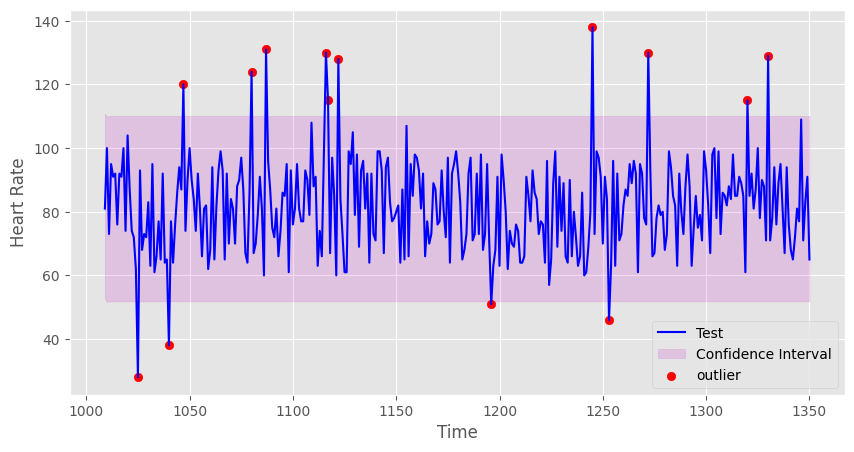

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(df_test['idx'], df_test['heart_rate1'], label="Test", color ='b')

plt.fill_between(df_test['idx'], df_test['lower'], df_test['upper'] , alpha=0.15, label='Confidence Interval', color = 'm')

# 추출된 행을 빨간 점으로 표시
plt.scatter(out_of_confidence_interval['idx'], out_of_confidence_interval['heart_rate1'], color='red', label="outlier")

plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.legend()
plt.show()

In [ ]:
from google.colab import files
df_test.to_csv('ARIMA(uniform_allpredict).csv', index=False)


# CSV 파일 다운로드
#files.download('ARIMA(uniform_allpredict).csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>